# Using SHAP values and IntegratedGradients for cell type classification interpretability

Previously we saw semi-supervised models, like SCANVI being used for tasks like cell type classification, enabling researchers to uncover complex biological patterns. However, as these models become more sophisticated, it is essential to understand not just the predictions they make, but why they make them. This is where interpretability methods like [SHAP (SHapley Additive exPlanations)](https://shap.readthedocs.io/en/latest/generated/shap.DeepExplainer.html#shap.DeepExplainer) and [CAPTUM IntegratedGradients](https://captum.ai/api/integrated_gradients.html) come into play. By providing insights into the influence of individual features on model predictions, these methods help us trust and validate our models in critical biological contexts. 

In this tutorial, we'll explore the significance of interpretability techniques in supervised cell classification using ScanVI, which are now avialble as part of SCVI-Tools. 

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

/home/access/anaconda3/lib/python3.12/site-packages/scvi_colab/_core.py:47: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import scvi
import seaborn as sns
import torch

torch.set_float32_matmul_precision("high")

/home/access/anaconda3/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/access/anaconda3/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/access/anaconda3/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/access/anaconda3/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/access/anaconda3/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.i

## Load data and tain scanvi

In this tutorial we will be using the dataset of peripheral blood mononuclear cells from 10x Genomics, [PBMC dataset](https://docs.scvi-tools.org/en/stable/api/reference/scvi.data.pbmc_dataset.html#scvi.data.pbmc_dataset)

In [3]:
adata = scvi.data.pbmc_dataset()
adata.layers["counts"] = adata.X.copy()
adata.obs["batch"] = adata.obs["batch"].astype("category")
adata

INFO     File data/gene_info_pbmc.csv already downloaded                                                           
INFO     File data/pbmc_metadata.pickle already downloaded                                                         
INFO     File data/pbmc8k/filtered_gene_bc_matrices.tar.gz already downloaded                                      
INFO     Extracting tar file                                                                                       
INFO     Removing extracted data at data/pbmc8k/filtered_gene_bc_matrices                                          
INFO     File data/pbmc4k/filtered_gene_bc_matrices.tar.gz already downloaded                                      
INFO     Extracting tar file                                                                                       
INFO     Removing extracted data at data/pbmc4k/filtered_gene_bc_matrices                                          


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/_built_in_data/_pbmc.py:75: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = pbmc8k.concatenate(pbmc4k)


AnnData object with n_obs × n_vars = 11990 × 3346
    obs: 'n_counts', 'batch', 'labels', 'str_labels'
    var: 'gene_symbols', 'n_counts-0', 'n_counts-1', 'n_counts'
    uns: 'cell_types'
    obsm: 'design', 'raw_qc', 'normalized_qc', 'qc_pc'
    layers: 'counts'

In [4]:
adata.var_names = adata.var["gene_symbols"]

In [5]:
adata.obs.str_labels.value_counts()  # list of classes and their observations

str_labels
CD4 T cells          4996
CD14+ Monocytes      2227
B cells              1621
CD8 T cells          1448
Other                 463
NK cells              457
FCGR3A+ Monocytes     351
Dendritic Cells       339
Megakaryocytes         88
Name: count, dtype: int64

In [6]:
print("# cells, # genes before filtering:", adata.shape)

sc.pp.filter_genes(adata, min_counts=3)
sc.pp.filter_cells(adata, min_counts=3)

# cells, # genes before filtering: (11990, 3346)


In [7]:
# We select a small number of genes here, so our later interpretability analysis will be fast
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=200,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="batch",
)
print("# cells, # genes after filtering:", adata.shape)

# cells, # genes after filtering: (11990, 200)


In [8]:
scvi.model.SCANVI.setup_anndata(
    adata,
    layer="counts",
    batch_key="batch",
    labels_key="str_labels",
    unlabeled_category="unknown",
)

In [9]:
model = scvi.model.SCANVI(adata)
model

ScanVI Model with the following params: 
unlabeled_category: unknown, n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb
Training status: Not Trained
Model's adata is minified?: False

In [10]:
model.train(
    max_epochs=100,
    early_stopping=True,
    check_val_every_n_epoch=1,
    train_size=0.8,
    validation_size=0.2,
    accelerator="gpu",
    devices=-1,
    strategy="ddp_notebook_find_unused_parameters_true",
)

INFO     Training for 100 epochs.                                                                                  


/home/access/anaconda3/lib/python3.12/site-packages/scvi/train/_trainrunner.py:81: UserWarning: early_stopping was automaticaly disabled due to the use of DDP
  self.trainer = self._trainer_cls(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 2 processes
----------------------------------------------------------------------------------------------------

LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/access/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider inc

Training:   0%|          | 0/100 [00:00<?, ?it/s]

/home/access/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:431: It is recommended to use `self.log('train_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/home/access/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:431: It is recommended to use `self.log('train_classification_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/home/access/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:431: It is recommended to use `self.log('train_accuracy', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/home/access/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:431: It is re

## Inspect scanvi training and test performance

In [11]:
adata.obsm["X_scANVI"] = model.get_latent_representation()

In [12]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="X_scANVI", n_neighbors=30)

In [13]:
sc.tl.umap(adata, min_dist=0.3)

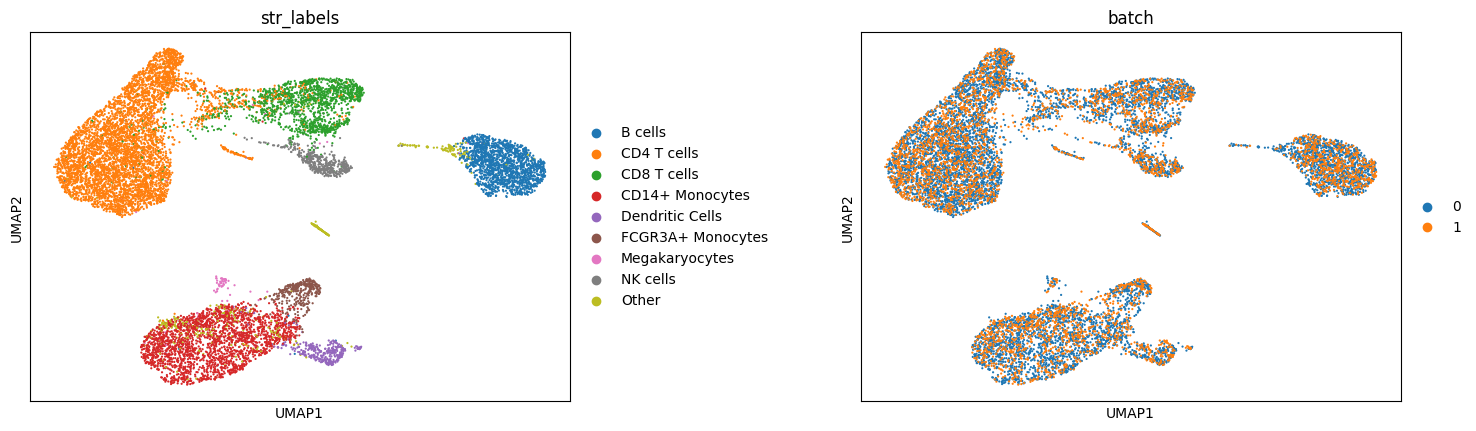

In [14]:
sc.pl.umap(adata, color=["str_labels", "batch"], ncols=2, wspace=0.4)

Next we will apply the 2 techniques for features interpretability and compare between them

## Integrated Gradients

Integrated Gradients is a robust interpretability technique that attributes the output of a model to its input features by calculating the cumulative sum of gradients along a path from a baseline (typically zero or a neutral input) to the actual input. This approach provides a way to measure how each feature contributes to the model's output in a smooth and consistent manner.

It is availble for any semi supervised model in SCVI-Tools by passing the ig_interpretability=True flag to the predict function.

In [15]:
predictions, attributions = model.predict(ig_interpretability=True)

The method works relatievely fast and we can then plot the gene table with their importnace mean and variance, overall for all cell - types

In [16]:
n_plot = 15
attributions.head(n_plot)

,gene,gene_idx,attribution_mean,attribution_std,cells
0,S100A4,18,0.451401,0.615315,11990
1,TYROBP,179,0.179418,0.325539,11990
2,S100A6,17,0.159837,0.249992,11990
3,S100A9,15,0.130546,0.352899,11990
4,NKG7,186,0.125753,0.293756,11990
5,LGALS2,196,0.108985,0.229961,11990
6,IL32,148,0.102592,0.174431,11990
7,GZMK,62,0.085330,0.262654,11990
8,HLA-DPB1,81,0.084460,0.273015,11990
9,CSTA,41,0.069941,0.174467,11990


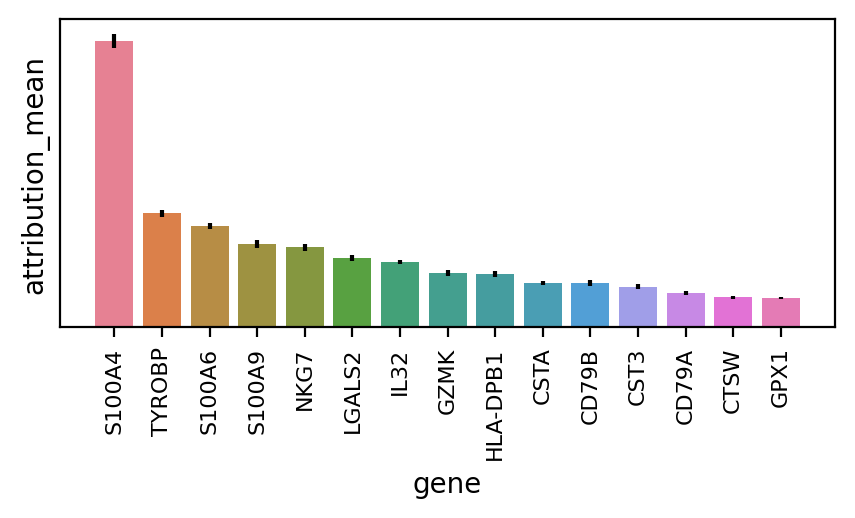

In [17]:
df = attributions.head(n_plot)
ci = 1.96 * df["attribution_std"] / np.sqrt(df["cells"])
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 2), dpi=200)
sns.barplot(ax=ax, data=df, x="gene", y="attribution_mean", hue="gene", dodge=False)
ax.set_yticks([])
plt.tick_params(axis="x", which="major", labelsize=8, labelrotation=90)
ax.errorbar(
    df["gene"].values,
    df["attribution_mean"].values,
    yerr=ci,
    ecolor="black",
    fmt="none",
)
if ax.get_legend() is not None:
    ax.get_legend().remove()

We can repeat for specific class ('Dendritic Cells'):

In [18]:
predictions_class, attributions_class = model.predict(
    indices=np.where(adata.obs.str_labels == "Dendritic Cells")[0].tolist(),
    ig_interpretability=True,
)

In [19]:
attributions_class.head(n_plot)

,gene,gene_idx,attribution_mean,attribution_std,cells
0,S100A4,18,1.152516,0.386783,339
1,HLA-DPB1,81,1.113057,0.300992,339
2,CST3,166,0.608530,0.287984,339
3,LGALS2,196,0.606281,0.250443,339
4,TYROBP,179,0.496806,0.232269,339
5,FCER1A,21,0.379987,0.279442,339
6,COTL1,154,0.251771,0.143787,339
7,S100A6,17,0.232539,0.186305,339
8,GSTP1,113,0.202374,0.120685,339
9,FGL2,87,0.187787,0.156393,339


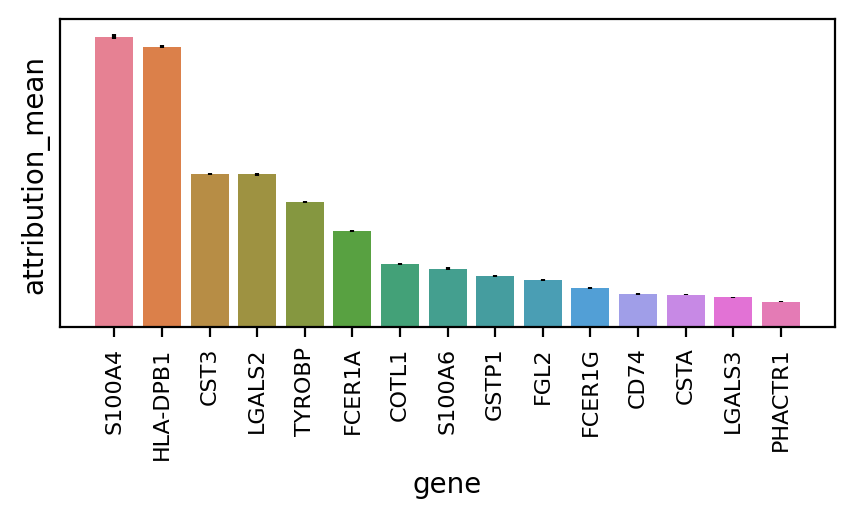

In [20]:
df_class = attributions_class.head(n_plot)
ci = 1.96 * df["attribution_std"] / np.sqrt(df["cells"])
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 2), dpi=200)
sns.barplot(ax=ax, data=df_class, x="gene", y="attribution_mean", hue="gene", dodge=False)
ax.set_yticks([])
plt.tick_params(axis="x", which="major", labelsize=8, labelrotation=90)
ax.errorbar(
    df_class["gene"].values,
    df_class["attribution_mean"].values,
    yerr=ci,
    ecolor="black",
    fmt="none",
)
if ax.get_legend() is not None:
    ax.get_legend().remove()

As expected, for a specific class, we can see different important genes, altough S100A4 is still the top contributer

## SHAP

SHAP (SHapley Additive exPlanations) values are a popular interpretability technique based on cooperative game theory. The core idea is to fairly allocate the "credit" for a model's prediction to each feature, by considering all possible combinations of features and their impact on the prediction. SHAP values are additive, meaning the sum of the SHAP values for all features equals the difference between the model’s output and the average prediction. This method works for any model type, providing a consistent way to explain individual predictions, making it highly versatile and widely applicable. Deep SHAP is an extension of the SHAP method designed specifically for deep learning models, such as the ones in SCVI-Tools. For more information see [this]("https://www.nature.com/articles/s41592-024-02511-3")

Calcualtion of SHAP for SC data usually takes a lot of time. In SCVI-Tools we are running an approximation of SHAP in order to reduce runtime, where we use just 100 cells at each iteration.

In [21]:
shap_values = model.shap_predict()

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 1 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 7 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 7 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(


  0%|          | 0/100 [00:00<?, ?it/s]

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-pac

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-pac

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-pac

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-pac

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-pac

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-pac

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-pac

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-pac

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-pac

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-pac

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-pac

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-pac

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-pac

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-pac

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-pac

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-pac

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-pac

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-pac

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-pac

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-pac

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-pac

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-pac

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-pac

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-pac

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-pac

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-pac

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-pac

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-pac

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-pac

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-pac

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(


INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(


INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-pac

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-pac

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-pac

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-pac

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-pac

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-pac

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 2 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/access/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [30]:
adata.obs.str_labels.cat.categories

Index(['B cells', 'CD4 T cells', 'CD8 T cells', 'CD14+ Monocytes',
       'Dendritic Cells', 'FCGR3A+ Monocytes', 'Megakaryocytes', 'NK cells',
       'Other'],
      dtype='object')

In [32]:
# select the class label we wish to understand
shap_top_features = model.get_ranked_genes(attrs=shap_values[:, :, 4]).head(n_plot)
print(shap_top_features)

         gene  gene_idx  attribution_mean  attribution_std  cells
0       IL2RB       195          0.000012         0.000041    100
1      RNASE6       134          0.000008         0.000043    100
2    DNASE1L3        40          0.000006         0.000041    100
3     TSPAN13        86          0.000006         0.000039    100
4       CXCL3        52          0.000006         0.000042    100
5       SMPD3       153          0.000005         0.000036    100
6        CD1C        19          0.000005         0.000038    100
7        FGL2        87          0.000005         0.000043    100
8   HIST1H2AC        76          0.000005         0.000040    100
9       CSF1R        69          0.000005         0.000039    100
10       NRGN       115          0.000004         0.000031    100
11     CXCL10        55          0.000004         0.000040    100
12     AKR1C3       116          0.000004         0.000037    100
13    ALOX5AP       132          0.000004         0.000039    100
14       M

And we can see some overlapping genes from the 2 methods for this specific group of cells

Work in progress: please check back in the next release!